In [1]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from project3.gans.dcgan import Generator, Discriminator
from project3.train import  fit
from datetime import datetime
from pandas import DataFrame
from torchvision.utils import save_image


# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

c:\Users\gosia\Desktop\studia\mgr_sem_1\DL\python2\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Random Seed:  999


In [2]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [3]:
dataroot = "project3/data/data0"
workers = 2
batch_size = 128
image_size = 64
nc = 3
nz = 100
ngf = 64
ndf = 64
num_epochs = 5
lr = 0.0002
beta1 = 0.5
# Decide which device we want to run on
device = 'cpu'

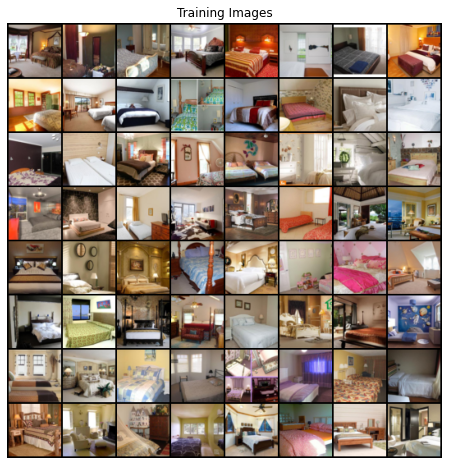

In [4]:
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)



# Plot some training images
real_batch =next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [5]:
# Generator init
netG = Generator( ngf, nz, nc).to(device = device)
netG.apply(weights_init)

# Discriminator init

netD = Discriminator(ndf, nc).to(device = device)
netD.apply(weights_init)

Discriminator(
  (cnn1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (cnn2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (cnn3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (cnn4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (cnn5): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lrelu): LeakyReLU(negative_slope=0.2, inplace=True)
)

In [6]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# batch of latent vectors
fixed_noise = torch.randn(64, nz, 1, 1, device=device)



optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [7]:
len(dataloader)*batch_size

303232

In [8]:
netG.load_state_dict(torch.load('C:\\Users\\gosia\\Desktop\\studia\\mgr_sem_1\\DL\\cifar10-computer_vision\\project3\\results\\2_14_43\\generator'))
netD.load_state_dict(torch.load('C:\\Users\\gosia\\Desktop\\studia\\mgr_sem_1\\DL\\cifar10-computer_vision\\project3\\results\\2_14_43\\discriminator'))

<All keys matched successfully>

In [9]:

modelG, modelD, history, img_list \
 = fit(netG, netD, dataloader,  optimizerG ,optimizerD , criterion,fixed_noise,  epochs=3, device="cpu", is_logging=False, epoch_logging=5, trial_name=None, checkpoint_path=None)

  0%|          | 0/5000 [00:00<?, ?it/s]c:\Users\gosia\Desktop\studia\mgr_sem_1\DL\python2\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
c:\Users\gosia\Desktop\studia\mgr_sem_1\DL\python2\lib\site-packages\torch\nn\functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
  0%|          | 3/5000 [00:08<4:02:05,  2.91s/it]

In [ ]:
today = datetime.today()
today_folder = "_".join( [str(today.day), str(today.hour), str(today.minute)])
folder = os.path.join('project3', 'results',today_folder)
os.makedirs(folder)
modelD.save(folder)
modelG.save(folder)
DataFrame(history).to_csv(os.path.join(folder, 'losses.csv'))

In [ ]:
for i in range(10):
    save_image(modelG.generate_image(batch_size = 1, nz = 100, device = 'cpu'), os.path.join(folder, f"img_{i}.jpg"))